<a href="https://colab.research.google.com/github/santiagonajera/LocalizacionCentrosDeDistribucion/blob/main/CentrosDeDistribucionOptimoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cargando datos desde GitHub...
Datos cargados exitosamente: 51 ciudades
Demanda total: 515,200 pallets/año

Analizando el número óptimo de centros de distribución...


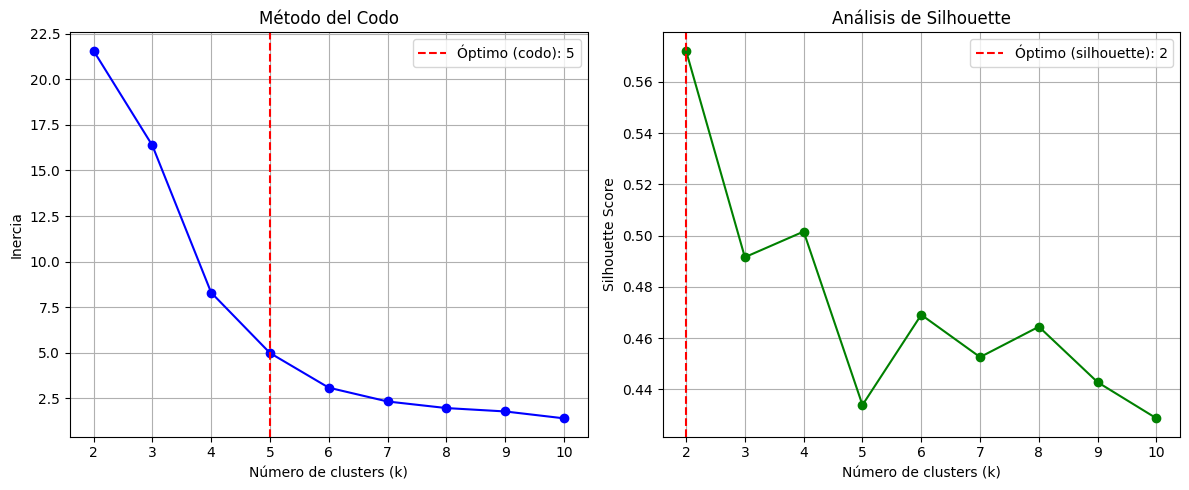


Resultados del análisis:
Número óptimo de centros (método del codo): 5
Número óptimo de centros (silhouette score): 2
Número sugerido de centros: 4

Centros de distribución recomendados (4 centros):
Centro 1: Tijuana (Demanda: 28,000 pallets/año)
Centro 2: Querétaro (Demanda: 9,500 pallets/año)
Centro 3: Chihuahua (Demanda: 16,000 pallets/año)
Centro 4: Mérida (Demanda: 18,000 pallets/año)

Estadísticas por cluster:
Cluster 1 (Tijuana): 2 ciudades, 42,000 pallets/año
Cluster 2 (Querétaro): 31 ciudades, 354,900 pallets/año
Cluster 3 (Chihuahua): 10 ciudades, 79,200 pallets/año
Cluster 4 (Mérida): 8 ciudades, 39,100 pallets/año

Mapa generado con 4 centros de distribución
Mapa muestra:
- Marcadores azules/coloreados: ciudades por cluster
- Estrellas rojas: centros de distribución recomendados
- Círculos: áreas de influencia estimadas (100km)


In [5]:
import folium
import math
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import display
import urllib.request
import matplotlib.pyplot as plt

# Leer datos desde el archivo de texto (local o URL)
def leer_datos_txt(ruta_archivo):
    ciudades = []
    latitudes = []
    longitudes = []
    demandas = []

    # Si es una URL, descargar el contenido
    if ruta_archivo.startswith('http'):
        with urllib.request.urlopen(ruta_archivo) as response:
            contenido = response.read().decode('utf-8')
            lineas = contenido.strip().split('\n')

        # Procesar las líneas
        for i, linea in enumerate(lineas):
            if i == 0:  # Saltar encabezado
                continue
            partes = linea.strip().split('\t')
            if len(partes) >= 4:  # Verificar que la línea tenga suficientes datos
                ciudades.append(partes[0])
                latitudes.append(float(partes[1]))
                longitudes.append(float(partes[2]))
                demandas.append(int(partes[3]))
    else:
        # Archivo local
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            next(archivo)  # Saltar la primera línea (encabezado)
            for linea in archivo:
                partes = linea.strip().split('\t')
                if len(partes) >= 4:  # Verificar que la línea tenga suficientes datos
                    ciudades.append(partes[0])
                    latitudes.append(float(partes[1]))
                    longitudes.append(float(partes[2]))
                    demandas.append(int(partes[3]))

    return ciudades, latitudes, longitudes, demandas

# Función para determinar el número óptimo de centros usando el método del codo
def determinar_numero_optimo_centros(X, pesos, max_k=10):
    inercias = []
    silhouette_scores = []
    k_values = range(2, min(max_k + 1, len(X)))

    for k in k_values:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(X, sample_weight=pesos)
        inercias.append(kmeans.inertia_)

        # Calcular silhouette score
        if k < len(X):
            score = silhouette_score(X, kmeans.labels_)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(0)

    # Encontrar el "codo" usando el método de la diferencia de gradientes
    diferencias = np.diff(inercias)
    diferencias2 = np.diff(diferencias)
    codo_idx = np.argmax(diferencias2) + 2  # +2 porque empezamos en k=2
    k_optimo_codo = k_values[codo_idx] if codo_idx < len(k_values) else k_values[-1]

    # K óptimo por silhouette score
    k_optimo_silhouette = k_values[np.argmax(silhouette_scores)]

    # Graficar el método del codo
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_values, inercias, 'bo-')
    plt.axvline(x=k_optimo_codo, color='r', linestyle='--', label=f'Óptimo (codo): {k_optimo_codo}')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouette_scores, 'go-')
    plt.axvline(x=k_optimo_silhouette, color='r', linestyle='--', label=f'Óptimo (silhouette): {k_optimo_silhouette}')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Análisis de Silhouette')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return k_optimo_codo, k_optimo_silhouette, inercias, silhouette_scores

# Función para calcular la distancia euclidiana
def distancia_euclidiana(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Función para encontrar la ciudad más cercana a un centro de cluster
def encontrar_ciudad_cercana(centro_cluster, coordenadas, demandas_dict):
    min_distancia = float('inf')
    ciudad_cercana = None
    coord_cercana = None

    for ciudad, coord in coordenadas.items():
        distancia = distancia_euclidiana(centro_cluster, coord)
        if distancia < min_distancia:
            min_distancia = distancia
            ciudad_cercana = ciudad
            coord_cercana = coord

    return ciudad_cercana, coord_cercana

# Cargar datos desde la URL de GitHub
url_archivo = 'https://raw.githubusercontent.com/santiagonajera/LocalizacionCentrosDeDistribucion/refs/heads/main/CordenadasMexico.txt'
print("Cargando datos desde GitHub...")
ciudades, latitudes, longitudes, demandas = leer_datos_txt(url_archivo)

print(f"Datos cargados exitosamente: {len(ciudades)} ciudades")
print(f"Demanda total: {sum(demandas):,} pallets/año")

# Crear diccionarios con los datos
coordenadas = {ciudad: (lat, lon) for ciudad, lat, lon in zip(ciudades, latitudes, longitudes)}
demandas_dict = dict(zip(ciudades, demandas))

# Preparar datos para k-means
X = np.array(list(coordenadas.values()))
demandas_list = np.array(demandas)

# Normalizar la demanda para usarla como peso
pesos = demandas_list / sum(demandas_list)

# Determinar el número óptimo de centros de distribución
print("\nAnalizando el número óptimo de centros de distribución...")
k_codo, k_silhouette, inercias, scores = determinar_numero_optimo_centros(X, pesos, max_k=10)

print(f"\nResultados del análisis:")
print(f"Número óptimo de centros (método del codo): {k_codo}")
print(f"Número óptimo de centros (silhouette score): {k_silhouette}")

# Usar el promedio de ambos métodos como sugerencia
k_sugerido = round((k_codo + k_silhouette) / 2)
print(f"Número sugerido de centros: {k_sugerido}")

# Aplicar K-means con el número sugerido de centros
kmeans = KMeans(n_clusters=k_sugerido, init='k-means++', random_state=42).fit(X, sample_weight=pesos)
etiquetas = kmeans.labels_
centros_clusters = kmeans.cluster_centers_

# Encontrar las ciudades reales más cercanas a cada centro de cluster
centros_reales = []
nombres_centros = []

for i, centro_cluster in enumerate(centros_clusters):
    ciudad_cercana, coord_cercana = encontrar_ciudad_cercana(centro_cluster, coordenadas, demandas_dict)
    centros_reales.append(coord_cercana)
    nombres_centros.append(ciudad_cercana)

# Mostrar los centros de distribución recomendados
print(f"\nCentros de distribución recomendados ({k_sugerido} centros):")
for i, centro in enumerate(nombres_centros):
    demanda_centro = demandas_dict[centro]
    print(f"Centro {i+1}: {centro} (Demanda: {demanda_centro:,} pallets/año)")

# Calcular estadísticas por cluster
print(f"\nEstadísticas por cluster:")
for i in range(k_sugerido):
    ciudades_cluster = [ciudades[j] for j in range(len(ciudades)) if etiquetas[j] == i]
    demanda_cluster = sum([demandas_dict[ciudad] for ciudad in ciudades_cluster])
    print(f"Cluster {i+1} ({nombres_centros[i]}): {len(ciudades_cluster)} ciudades, {demanda_cluster:,} pallets/año")

# Crear mapa centrado en México
lat_promedio = np.mean(latitudes)
lon_promedio = np.mean(longitudes)

mapa = folium.Map(location=[lat_promedio, lon_promedio], zoom_start=5)

# Colores para diferentes clusters
colores = ['blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue']

# Agregar marcadores para cada ciudad
for i, (ciudad, coord) in enumerate(coordenadas.items()):
    cluster = etiquetas[i]
    color = colores[cluster % len(colores)]

    folium.Marker(
        location=coord,
        popup=f"{ciudad}<br>Demanda: {demandas_dict[ciudad]:,} pallets<br>Cluster: {cluster + 1}",
        icon=folium.Icon(color=color, icon="info-sign")
    ).add_to(mapa)

# Agregar marcadores para los centros de distribución
for i, (centro, nombre) in enumerate(zip(centros_reales, nombres_centros)):
    folium.Marker(
        location=centro,
        popup=f"<b>Centro de Distribución {i+1}</b><br>{nombre}<br>Demanda: {demandas_dict[nombre]:,} pallets",
        icon=folium.Icon(color="red", icon="star", icon_size=(15, 15))
    ).add_to(mapa)

# Agregar círculos para mostrar la influencia de cada centro
for i, centro in enumerate(centros_reales):
    folium.Circle(
        location=centro,
        radius=100000,  # 100 km de radio
        popup=f"Área de influencia Centro {i+1}",
        color=colores[i % len(colores)],
        weight=2,
        fill=True,
        fillOpacity=0.1
    ).add_to(mapa)

print(f"\nMapa generado con {k_sugerido} centros de distribución")
print("Mapa muestra:")
print("- Marcadores azules/coloreados: ciudades por cluster")
print("- Estrellas rojas: centros de distribución recomendados")
print("- Círculos: áreas de influencia estimadas (100km)")

# Mostrar el mapa
display(mapa)